## Minimum Spectral Entropy Demonstration

This notebook demonstrates a method for controlling temporal phase noise in $H(\nu,t)\exp(i\phi_t)$, where $H(\nu,t)$ is the dynamic frequency response determined by dynamic cyclic spectroscopy, and $\phi_t$ is the unknown degenerate phase.

Two methods are used:

1. minimizing the phase difference between adjacent time samples
2. minimizing the spectral entropy in $h(\tau,\omega)$

In [1]:
from scipy.fft import rfft, fft, fftshift, ifft, fftn, ifftn
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
import psrchive

def freq2time(hf, axis=0):
    return ifft(hf, axis=axis, norm="ortho")

def time2freq(ht, axis=0):
    return fft(ht, axis=axis, norm="ortho")

## Spectral Entropy

Defined as $$U = - \sum_j \sum_k p_{jk} \log_2 p_{jk},$$
where $p_{jk}$ is the fractional power spectral density,

\begin{equation}
p_{jk} = P_{jk} \Sigma_P^{-1},
\end{equation}

$P_{jk} = | h^\prime(\tau_j;\omega_k) |^2$ is the power at a
given delay and Doppler shift, 
$h^\prime(\tau_j;\omega_k)$ is the forward DFT of $h^\prime(\tau;t)=h(\tau;t)\exp(i\phi_t)$, and

\begin{equation}
\Sigma_P =  \sum_m \sum_n P_{mn}
\end{equation}

is the total power summed over all delays and Doppler shifts, which remains constant
as the values of $\phi_t$ are varied.

In [2]:
def spectral_entropy_grad(phi, h_time_delay):
    """
    Calculates the total spectral entropy of the time-to-Doppler forward Fourier transform 
    of the input h_time_delay after phase shifting each row/time (except the first) by phi

    Args:
    phi: A 1D array of (Ntime - 1) real-valued phase shifts, in radians, to be applied to each row except the first
    h_time_delay: A 2D array of Ntime * Ndelay complex-values; each row of the dynamic impulse response is multiplied by a phasor defined by x

    Returns:
    The spectral entropy and its gradient with respect to the phase shifts
    """

    Ntime, M = h_time_delay.shape
    
    phs = np.zeros(Ntime)
    phs[1:] = phi
    phasors = np.exp(1.j * phs)
    h_time_delay_prime = np.multiply(h_time_delay, phasors[:, np.newaxis])
    h_doppler_delay_prime = fft(h_time_delay_prime, axis=0, norm="ortho")
    power_spectrum = np.abs(h_doppler_delay_prime)**2
    
    total_power = np.sum(power_spectrum)
    power_spectrum /= total_power
    log_power_spectrum = np.log2(power_spectrum + 1e-16)
    entropy = -np.sum(power_spectrum * log_power_spectrum)
    
    weighted_ifft = ifft((1.+log_power_spectrum)*h_doppler_delay_prime, axis=0, norm="ortho")

    gradient = 2.0/total_power * np.sum( np.imag( np.conj(weighted_ifft)*h_time_delay_prime ), axis=1)
    grad_power = np.sum(gradient**2)

    rms = np.sqrt(np.sum(phi**2) / (Ntime-1))
    print (f"rms={rms:.4g} rad; S={entropy} grad power={grad_power:.4}")

    return entropy, gradient[1:]

def spectral_entropy(h_time_delay):
    """
    Calculates the total spectral entropy of the time-to-Doppler forward Fourier transform 
    of the input h_time_delay

    Args:
    h_time_delay: A 2D array of Ntime * Ndelay complex-values; the dynamic impulse response

    Returns:
    The spectral entropy
    """
    nsub, nchan = h_time_delay.shape
    phs = np.zeros(nsub-1)
    entropy, grad = spectral_entropy_grad(phs,h_time_delay)
    return entropy

## Simulated scattering screen

Load a simulated dynamic response, $H(\nu,t)$ that was generated using 

    dyn_resp_sim input.ar -w1
    
This generates a single scintillation arc with a Gaussian width of one pixel.  The following code also plots $h(\tau,\omega)$ and reports the original entropy.

**Note the original spectral entropy of 7.656.**

rms=0 rad; S=7.655846160338721 grad power=0.0003736
Spectral Entropy: 7.655846160338721
Total Power: 53713372.647638835


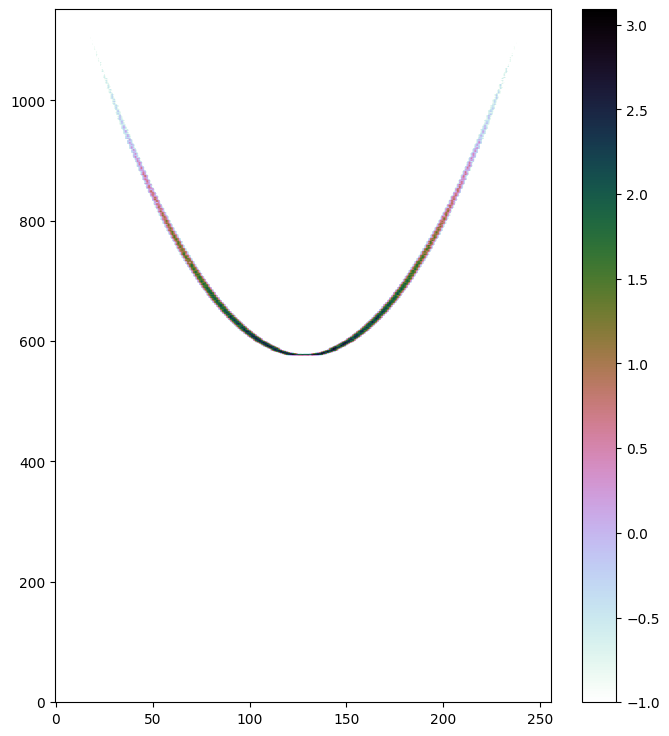

In [3]:
filename = "test/dyn_resp_sim.fits"
ar = psrchive.Archive_load(filename)
ext = ar.get_dynamic_response()
data = ext.get_data()
nchan = ext.get_nchan()
ntime = ext.get_ntime()
h_time_freq = np.reshape(data, (ntime, nchan))

def plot (h_time_freq):
    h_time_delay = freq2time(h_time_freq, axis=1)
    print(f"Spectral Entropy: {spectral_entropy(h_time_delay)}")
    h_doppler_delay = time2freq(h_time_delay, axis=0)
    power = np.sum(np.abs(h_doppler_delay)**2)
    print(f"Total Power: {power}")
    plotthis = np.log10(np.abs(fftshift(h_doppler_delay)) + 1e-2)
    fig, ax = plt.subplots(figsize=(8, 9))
    img = ax.imshow(plotthis.T, aspect="auto", origin="lower", cmap="cubehelix_r", vmin=-1)
    fig.colorbar(img)
    
plot(h_time_freq)

## Scramble the phases

Multiply each row of the dynamic frequency response by a random phase.

**Note how the spectral entropy is increased from 7.656 to 13.15.**

rms=0 rad; S=13.1561399555021 grad power=0.001529
Spectral Entropy: 13.1561399555021
Total Power: 53713372.647638835


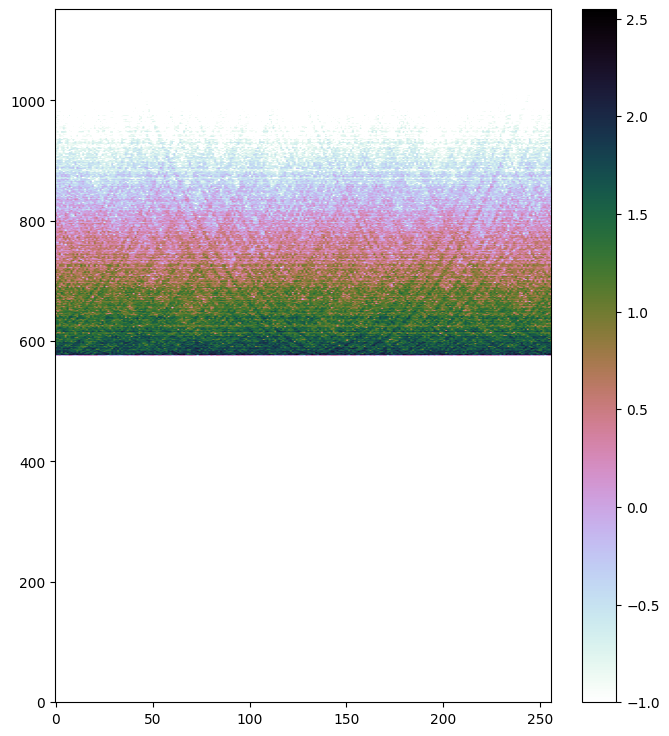

In [4]:
phases = np.random.uniform(-np.pi,np.pi,ntime)
phasors = np.exp( 1j * phases)
data_scrambled = np.multiply(h_time_freq, phasors[:, np.newaxis])
plot(data_scrambled)

## Minimize the phase differences

Multiply each row of the scrambled dynamic frequency response by a phase that makes the cross-correlation between adjacent rows real-valued (zero phase).

**Note how the spectral entropy decreases from 13.15 to 8.824.**

minimize_temporal_phase_noise power=2.0809903806584424
rms=0 rad; S=8.82444302584913 grad power=0.007544
Spectral Entropy: 8.82444302584913
Total Power: 53713372.64763883


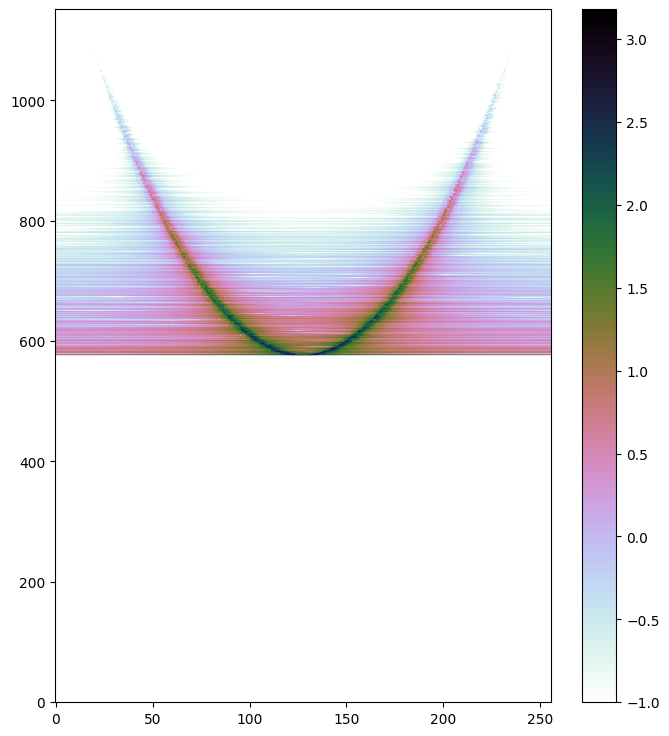

In [5]:
def minimize_temporal_phase_noise(x, ph):
    nspec=x.shape[0]
    xprev = x[0]
    zero = 1.0 + 0.0j
    power = 0.0
    for isub in range(1, nspec):
        z = (np.conj(x[isub]) * xprev).sum()
        z /= np.abs(z)
        ph[isub-1] = np.angle(z)
        x[isub] *= z
        diff = z - zero
        power += np.abs(diff) ** 2
        xprev = x[isub]

    power /= nspec - 1
    print(f"minimize_temporal_phase_noise power={power}")

phase_guesses = np.zeros(ntime-1)
minimize_temporal_phase_noise(data_scrambled, phase_guesses)
plot(data_scrambled)

## Minimize the spectral entropy

Multiply each row of the scrambled dynamic frequency response by a phase that minimizes the spectral entropy

**Note how the spectral entropy decreases from 8.824 to 7.653, which is lower than the original entropy, but there are still residual artefacts.**

In [6]:
from scipy.optimize import minimize

def circular(x):
    x[:] = np.fmod(x, 2.0*np.pi)

initial_guess = phase_guesses
data_scrambled = np.multiply(h_time_freq, phasors[:, np.newaxis])
h_time_delay = freq2time(data_scrambled, axis=1)
options = {'maxiter': 1000, 'disp': True}

result = minimize(spectral_entropy_grad, initial_guess, args=(h_time_delay,), method='BFGS', jac=True, callback=circular, options=options)
optimal_phases = result.x
print(result.message)

rms=1.854 rad; S=8.82444302584913 grad power=0.007544
rms=1.853 rad; S=8.817075718601345 grad power=0.007749
rms=1.853 rad; S=8.78676183490099 grad power=0.008663
rms=1.853 rad; S=8.653703475020752 grad power=0.01345
rms=1.892 rad; S=8.123057389711583 grad power=0.03051
rms=2.506 rad; S=10.022913107193684 grad power=0.04168
rms=1.925 rad; S=8.037721716799817 grad power=0.03505
rms=1.929 rad; S=8.012010005458162 grad power=0.03351
rms=1.944 rad; S=7.9252758680474376 grad power=0.02765
rms=1.962 rad; S=7.771143985364195 grad power=0.01324
rms=1.963 rad; S=7.750242755141647 grad power=0.0121
rms=1.962 rad; S=7.74530220136178 grad power=0.0113
rms=1.962 rad; S=7.7363824240211025 grad power=0.01018
rms=1.963 rad; S=7.722136249072845 grad power=0.008757
rms=1.968 rad; S=7.712720329418353 grad power=0.008571
rms=1.97 rad; S=7.710920833949657 grad power=0.00848
rms=1.972 rad; S=7.70775337108594 grad power=0.008254
rms=1.977 rad; S=7.70268810287568 grad power=0.00787
rms=1.984 rad; S=7.69731547

rms=0 rad; S=7.653491024694115 grad power=8.51e-10
Spectral Entropy: 7.653491024694115
Total Power: 53713372.64763884


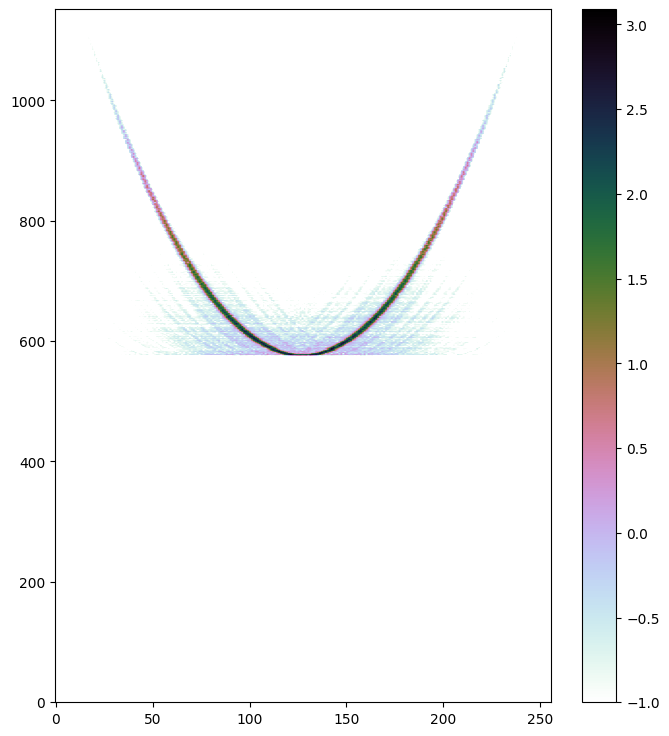

In [7]:
tmp = np.zeros(ntime)
tmp[1:] = optimal_phases
phasors = np.exp(1.j * tmp)
shifted_data = np.multiply(data_scrambled, phasors[:, np.newaxis])
plot(shifted_data)